https://stackoverflow.com/questions/53838696/problems-regarding-pyomo-provided-math-functions

https://stackoverflow.com/questions/70048818/optimization-of-a-battery-storage-with-pyomo

https://gitlab.com/diw-evu/emobpy/emobpy/-/blob/master/emobpy/data/evspecs.json

https://github.com/L-Strobel/jointAnalysisCharging/tree/main/chargingmodel

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt#
import matplotlib.axes as axes
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
import matplotlib.dates as mdates

## Data input 

In [2]:
V2G = False
short_or_long = "long" #short: short, medium, long
flex = "full" #constrained meaning that late charging cannot be applied to the fullest extent
soc_min = 0 #level that should preferably be reached as soon as possible

In [3]:
#emobpy import
processing_path = os.getcwd()
if short_or_long == "short": 
    os.chdir("../emobpy/short")
elif short_or_long == "medium": 
    os.chdir("../emobpy/medium")
else:
    os.chdir("../emobpy/long")
data_path = os.getcwd()
os.chdir(processing_path)
pics = os.path.join(processing_path, "Pictures","V2G" if V2G else "G2V", short_or_long)
if soc_min >0: 
    os.mkdir( os.path.join(processing_path, f"{soc_min}"))
    os.chdir(f"../{soc_min}")
    pics = os.getcwd()

pics_input = os.path.join(pics, "input")

    

consumption_ts = pd.read_pickle(os.path.join(data_path,  "consumption"))
consumption_ts = consumption_ts*1000/4  #W/h --> kW/15min_timestep
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path,  "properties")) 

profiles = min(consumption_ts.shape[1], availability_ts.shape[1], car_properties_raw.shape[1])
if short_or_long == "long":
    time_steps = len(availability_ts.dropna().index)
else: 
    days = 12
    time_steps = consumption_ts[consumption_ts.index.day<=days].shape[0]


In [4]:
car_properties_raw.iloc[0] = 1
car_properties_raw.iloc[1] = 1

In [5]:
#consumption = pd.DataFrame(data = np.array([[0, 0.5], [0, 0.5], [0.5, 0], [0.5, 0]]), columns = ["c_1[kW]", "c_2[kW]"])
#power = pd.DataFrame(pd.DataFrame(data = np.array([[1, 0], [1, 0], [0, 1], [0, 1]]), columns = ["p_1 [kW]", "p_2 [kW]"]))

#kWh / 15 min timestep
consumption_raw, power_raw, car_properties_raw = consumption_ts.iloc[:time_steps, :profiles].dropna(), availability_ts.iloc[:time_steps, :profiles].dropna(), car_properties_raw.iloc[:, :profiles].dropna()
neg_power_magnitude_raw = power_raw

#set datetime indexes 
index = consumption_ts.index[:time_steps]
consumption_raw.index, power_raw.index, neg_power_magnitude_raw.index = index, index, index

In [6]:
step_duration = int(pd.infer_freq(index)[:-1]) / 60  #parts of an hour

## Data plausibility

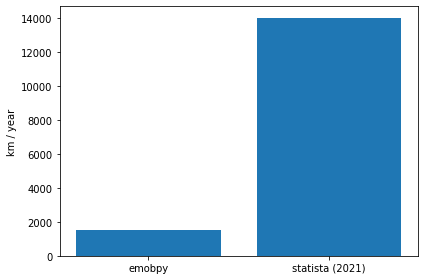

In [7]:
#average consumption of 200Wh per km  https://de.statista.com/statistik/daten/studie/183003/umfrage/pkw---gefahrene-kilometer-pro-jahr/, https://ev-database.de/cheatsheet/energy-consumption-electric-car 
#median in Germany is at about 11000 km per year
if soc_min ==0:  
    specific_consumption = 15 #for consumtion [kWh]  / [kWh/km]  = km
    scale = 365/len(consumption_raw.resample("D").sum().index)

    plot = plt.bar(
        ["emobpy", "statista (2021)"], [consumption_raw.sum(0).mean()*scale/specific_consumption, 14000]
           )
    plt.ylabel("km / year")
    plt.tight_layout()

    plt.savefig(os.path.join(pics_input, 'annual_mileage.png'),bbox_inches = "tight")

In [8]:
np.unique(power_raw.values) 

array([0.0, 3.33, 19.8], dtype=object)

In [9]:
#flexibility only available at home or at workplace 
flex_dict = {
    3.33 : {
        "time_steps" : 1    
    }
}
flex_dict[3.33]

{'time_steps': 1}

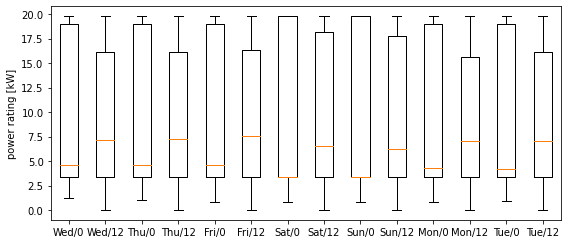

In [10]:
#power ratings are mostly between 3 and 20 kW 
if soc_min ==0:  
    ts = power_raw.loc[(index.day<=7) & (index.month==1)].resample("12h").mean()
    fig, ax = plt.subplots(figsize=(8, 3.5))
    ax.boxplot(
        ts.transpose(), labels= [d[:3] + "/" + str(h) for d, h in zip(ts.index.day_name(), ts.index.hour)],
          )

    plt.ylabel('power rating [kW]')

    fig.tight_layout()
    plt.savefig(os.path.join(pics_input, 'average_power_rating.png'), bbox_inches = "tight")

In [11]:
ts.max()

BEV280_W53_30bff_Renault_Zoe_Q90_2017                 19.800000
BEV670_W53_3bd17_Renault_Zoe_Q90_2017                 16.912500
BEV818_W53_02f1e_Tesla_Model_3_Long_Range_AWD_2019    16.981875
BEV416_W53_82582_Renault_Zoe_Q90_2017                 19.800000
BEV352_W53_47b54_Volkswagen_ID.3_2020                 19.800000
                                                        ...    
BEV111_W53_c7779_BMW_i3_33_kWh_2017                   19.800000
BEV390_W53_c1ba3_BMW_i3_33_kWh_2017                   19.800000
BEV157_W53_d532a_Renault_Zoe_Q90_2017                 19.800000
BEV805_W53_fdb96_FIAT_500e_2019                       19.800000
BEV110_W53_efcf5_Tesla_Model_3_Long_Range_AWD_2019    19.800000
Length: 5767, dtype: float64

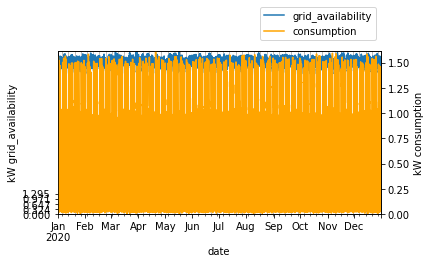

In [12]:
if soc_min ==0:  
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ts = power_raw.mean(1).resample("H").mean()
    ts_2 =  consumption_raw.mean(1).resample("H").mean()

    ax = ts.plot(ylabel="kW grid_availability", label = "grid_availability")

    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes',  1))

    ax2 = ts_2.plot(ylabel="kW consumption", color = "orange", label = "consumption")

    #.loc[index.day<=7].resample("2h").

    for i, s in enumerate([ts, ts_2]):
        if i == 0: 
            ax.set_ylim(s.min(), s.max())
        else:
            ax2.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax.set_yticks(np.arange(s.min(), s.max(), step_size))


    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="best", bbox_to_anchor=(1,1.3))

    ax.grid('on', which='minor', axis='x' )


    fig.tight_layout()


    plt.savefig(os.path.join(pics_input, 'consumtion_power_availability.png'), bbox_inches = "tight")

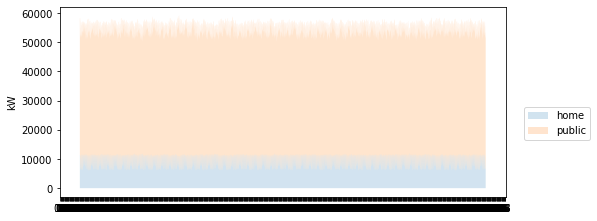

In [13]:
bottom = 0
rating = 1
rating_weighted = True
station_dict = {0.0 : "none",
               3.33 : "home",
               19.8: "public"}
fig, ax = plt.subplots(figsize=(8, 3.5))
i = 0

for r in np.unique(power_raw.values):
    if rating_weighted == True: 
        rating = r
        if (r != 0): 
            next_bottom = bottom+power_raw[power_raw==r].count(1)*rating 
        else: continue
        
    else: 
        next_bottom = bottom+power_raw[power_raw==r].count(1)*rating / power_raw.shape[1] *100
    if r in station_dict.keys(): l = station_dict[r] 
    else: 
        l = f'fast_{1}'
        i +=1
    
    plt.fill_between(x = power_raw.index,
                y1 = bottom,
                y2 = next_bottom,
                alpha = 0.2,
                label = l)
    bottom = next_bottom

ax.xaxis.set_major_locator(mdates.HourLocator(interval = 12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.ylabel('kW' if rating_weighted else "%")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0.5))

if soc_min ==0: plt.savefig(os.path.join(pics_input, f'home_charging_shares{"_per_cent" if rating_weighted else "_kw"}.png'),bbox_inches = "tight") 

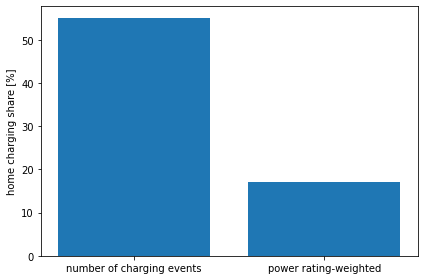

In [14]:
if soc_min ==0:  
    home_share_events = power_raw[power_raw==3.33].count().sum() / power_raw[power_raw>0].count().sum()*100
    home_share_rating = power_raw[power_raw==3.33].sum().sum() / power_raw.sum().sum()*100


    plot = plt.bar(
        ["number of charging events", "power rating-weighted"], [home_share_events, home_share_rating]
           )
    plt.ylabel("home charging share [%]")
    plt.tight_layout()

    plt.savefig(os.path.join(pics_input, 'home_charging_shares.png'),bbox_inches = "tight")

In [15]:
#https://www.agora-energiewende.de/en/service/recent-electricity-data/chart/power_generation/08.08.2021/08.08.2022/today/
german_peak = 73.3 #MW 30.11.2021
national_fleet_size = 10**6
scaling = national_fleet_size / consumption_raw.shape[0]
peak_load = consumption_raw.sum(1).nlargest(1).sum() #kW
print(peak_load) #kW 
print(peak_load*scaling*10**(-3) / german_peak) #kW --> MW

9796.492299610745
3.814191810260403


In [16]:
#plausibility:
#is the sum of the highest 10 consumption value assumed for one hour as constant lower than the average battery size?
(consumption_raw).mean(1).nlargest(10).sum() / car_properties_raw.iloc[2].mean()

0.28915364863543347

# EES-transformation: Generating uncontrolled and latest charging ts

In [17]:
#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [ ]:
solution_dict = {}
ees_constraints= pd.DataFrame()
M = 10000
failed_profiles = []

count = 0
for car in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[car].columns
    except AttributeError as a:
        car_list = [car]
        
    for i, c in enumerate(car_list):
        print(count)
        count =+ 1
        print(i) 
        print(c)
        
        if type(consumption_raw[c]) == pd.core.series.Series:
            consumption = consumption_raw[c]
            power = power_raw[car]
            neg_power_magnitude = neg_power_magnitude_raw[c]
            car_properties = car_properties_raw[c]

        else: 
            consumption = consumption_raw[c].iloc[:,i]
            power= power_raw[car].iloc[:,i]
            neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
            car_properties= car_properties_raw[c].iloc[:,i]
            

        solution_dict[car+str(i)] = {}
        battery_capacity = car_properties.loc["battery_capacity"]
        level_0 = car_properties["soc_init"]*battery_capacity
        level_T = car_properties.loc["soc_end"]*battery_capacity

        for model_type in ["m_early", "m_late"]:
            if (model_type == "m_late") & (car+str(i) in failed_profiles): 
                pass
            else:
                #Initialize model
                m = pyo.ConcreteModel()
                
                #initialize sets
                m.t = pyo.Set(initialize = index, ordered = True)

                #Initialize parameter
                m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
                m.power = pyo.Param(m.t, initialize=power.to_dict()) 
                m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

                #Initialize variables
                m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.SLACK = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
                m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                                  bounds = (0,battery_capacity))
                
                if ((model_type == "m_late") & (flex=="constrained")): ###
                    con = consumption_raw[car].iloc[:, i]
                    ava = power_raw[car].iloc[:, i]
                    
                    public_index = ava[(ava!=3.33)].index
                    dep_home_index = con[((con==0) & (con.shift(-1) > 0) == True) & (ava==3.33)].index
                    
                    m.t_pub = pyo.Set(initialize = public_index, ordered = True)
                    m.t_dep_home = pyo.Set(initialize = dep_home_index, ordered = True)
                    
                    def full_before_next_trip(m, t_dep): ####
                        if t_dep in  index[:2]:
                            return pyo.Constraint.Skip
                        else:
                            t_dep_1 = pd.Timestamp(t_dep) - pd.Timedelta(flex_dict[3.33]["time_steps"]*pd.infer_freq(index))
                            return m.LEVEL[t_dep_1] >= solution_dict[car+str(i)]["m_early"]["level"].loc[t_dep_1]
                    m.Full_before_next_trip = pyo.Constraint(m.t_dep_home, rule=full_before_next_trip)
                            
                    def public_uncontrolled(m, t_dep):  
                        return m.LEVEL[t_dep] >= solution_dict[car+str(i)]["m_early"]["level"].loc[t_dep]
                    m.Public_uncontrolled = pyo.Constraint(m.t_pub, rule=public_uncontrolled)
                    
                #level constraints
                def recursive_level(m, t):
                    if t == index[0]:
                        return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration
                    else:    
                        return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                         pd.Timedelta(pd.infer_freq(index))] + (
                            m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )*step_duration   
                m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

                def final_level(m, t):
                    if t == index[-1]:
                        return m.LEVEL[t] == level_T
                    else: 
                        return pyo.Constraint.Skip
                m.Final_level = pyo.Constraint(m.t, rule=final_level)

                #bidirectional charging 
                def neg_power_min(m, t):
                    if V2G == True:
                        return m.DISCHARGE[t] <= m.neg_power[t] 
                    else:
                        return m.DISCHARGE[t] ==0
                m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

                def power_max(m, t):
                    return m.CHARGE[t] <= m.power[t]   
                m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)

                def avoid_min_level(m, t):
                    return m.LEVEL[t] + m.SLACK[t] >= battery_capacity*soc_min
                m.Avoid_min_level = pyo.Constraint(m.t, rule=avoid_min_level)

                def battery_level_sum(m, t):    
                    if model_type == "m_late":
                        return sum(m.LEVEL[t] + M * m.SLACK[t] for t in m.t) 
                    else:
                        return sum(m.LEVEL[t] for t in m.t) 
                if model_type == "m_late": sense = pyo.minimize
                else: sense = pyo.maximize


                m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

                #find solver
                solvername='glpk'

                #prepare solver
                optimizer = opt.SolverFactory(solvername) 
                solved_model = optimizer.solve(m)      ##tee=True   

                if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                    failed_profiles.append(car+str(i))
                    print("failed")
                else:    
                    print("succeeded")
                    level_series = pd.concat([
                        pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                        pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                    ], axis=0)
                    charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                    discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])

                    #store data in dictionary
                    solution_dict[car+str(i)][model_type] = {}
                    solution_dict[car+str(i)][model_type]["level"] = level_series
                    solution_dict[car+str(i)][model_type]["charge"] = charge_df
                    solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
                    level_index = solution_dict[car+str(i)][model_type]["level"].index
solution_dict["failed_profiles"] = failed_profiles

0
0
Tesla/Model_3_Long_Range_AWD/2019
failed
1
1
Tesla/Model_3_Long_Range_AWD/2019


In [ ]:
if V2G: mode = "V2G" 
else: mode = "G2V"
    
with open(f'{short_or_long}_solution_dict_{mode}_{soc_min}.pickle', 'wb') as handle:
    pickle.dump(solution_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open(f'{short_or_long}_solution_dict_{mode}.pickle', 'rb') as handle:
 #   solution_dict = pickle.load(handle)
    
    

## Processing EES-profiles: Aggregation

In [ ]:
uncontrolled_level_accurate, uncontrolled_charge_df, early, late = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),pd.DataFrame()
df_con, df_pow, df_neg_pow, df_pro =  pd.DataFrame(), pd.DataFrame(),pd.DataFrame(),pd.DataFrame()

count = 0
for c in consumption_raw.columns.unique():
    try: 
        car_list = consumption_raw[c].columns
    except AttributeError as a:
        car_list = [c]

    for i, car in enumerate(car_list):
        if car+str(i) not in solution_dict["failed_profiles"] :
            print(count)
            if type(consumption_raw[car]) == pd.core.series.Series: 
                df_con[car] = consumption_raw[car]
                df_pow[car] = power_raw[car]
                df_neg_pow[car] = neg_power_magnitude_raw[car]
                df_pro[car] = car_properties_raw[car]
            else: 
                df_con[car+str(i)] = consumption_raw[car].iloc[:,i]
                df_pow[car+str(i)] = power_raw[car].iloc[:,i]
                df_neg_pow[car+str(i)] = neg_power_magnitude_raw[car].iloc[:,i]
                df_pro[car+str(i)] = car_properties_raw[car].iloc[:,i]
            try: 
                early = pd.concat([
                    early, solution_dict[car+str(i)]["m_early"]["level"]
                ], axis=1).sum(1)
                late = pd.concat([
                   late, solution_dict[car+str(i)]["m_late"]["level"]
                ], axis=1).sum(1)
                uncontrolled_charge_df = pd.concat([
                    uncontrolled_charge_df, solution_dict[car+str(i)]["m_early"]["charge"]
                ], axis=1)

            count += 1
            except KeyError: 
                pass

level_0_agg = sum(df_pro.loc["soc_init"]*df_pro.loc["battery_capacity"])
level_T_agg = sum(df_pro.loc["soc_end"]*df_pro.loc["battery_capacity"])   

uncontrolled_level_accurate = early
uncontrolled_level_accurate.iloc[0] = level_0_agg ##
uncontrolled_level_accurate.name = "uncontrolled_level"

uncontrolled_charge_accurate = uncontrolled_charge_df.sum(1)

uncontrolled_charge_accurate.name = "uncontrolled_charge"        
ees_constraints_aggergated=late-early

reduced = uncontrolled_charge_df
n_max = uncontrolled_charge_df.shape[1]
rmse = {}

for sample_size in range(10, n_max): 
    Y_true = reduced.max(1)
    Y_pred = reduced.iloc[:,:sample_size].max(1)
    rmse[f'{sample_size}'] = mean_squared_error(Y_true,Y_pred, squared=False) 
    
plt.scatter(range(10, n_max), rmse.values())
plt.xlabel("sample_size")
plt.ylabel("RMSE")
plt.ylim(0)
plt.show()

In [ ]:
#ees_constraints_aggergated = ees_constraints_aggergated.iloc[:time_steps+1, :profiles].sum(1)
level_index = ees_constraints_aggergated.index
aggregated_max_battery = df_pro.loc["battery_capacity"][ :profiles].sum()

In [ ]:
ax = pd.concat([
    -ees_constraints_aggergated*10**-3, pd.Series(aggregated_max_battery*10**-3,level_index)
], axis = 1, keys = ["ees", "aggregated_batteries"]).plot(ylabel="MWh", label = 'level_values')

ax.legend(bbox_to_anchor=(0.98,0.2))
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = pd.Series(100,level_index).plot(color="orange", ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)
ax.grid('on', which='minor', axis='x' )

plt.savefig(os.path.join(pics, 'ees_battery_comparison.png'), bbox_inches = "tight")

In [ ]:
consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_con.loc[level_index[1:]].sum(1)
              ], axis = 0)
consumption_aggregated.name = "consumption"

power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), df_neg_pow.loc[level_index[1:]].sum(1)
              ], axis = 0)

In [ ]:
#aggregation
naive_constraints_aggergated = pd.Series(data=sum(
    df_pro.loc["battery_capacity"][ :profiles]), index=level_index) #all battery capicities

In [ ]:
uncontrolled_charge_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), uncontrolled_charge_accurate.loc[level_index[1:]]
              ], axis = 0)

ts = uncontrolled_charge_accurate.loc[uncontrolled_charge_accurate.index.day <= 2].resample("h").mean()*10**-3
fig, ax = plt.subplots(1)

ax.step(ts.index, ts, where="post")
ax.set_ylabel("MW")
ax.set_xlabel("day")
ax.set_ylim(bottom=0)


ax.xaxis.set_major_locator(mdates.HourLocator(interval = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%D'))

plt.grid( axis='x' )

plt.savefig(os.path.join(pics, 'uncontrolled_charge.png'), bbox_inches = "tight")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax = (uncontrolled_level_accurate*10**-3).loc[level_index.day <= 7].resample("7D").mean().plot(label = 'level', ylabel="MWh")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ax2 = (uncontrolled_charge_accurate*10**-3).loc[index.day <= 7].resample("h").mean().plot(label = "charge", color="r", ylabel="MW")
ax2 = (consumption_aggregated*10**-3).loc[level_index.day <= 7].resample("h").mean().plot( label = "consumption", color="y")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))


ax.set_ylim(0), ax2.set_ylim(0)
ax.grid('on', which='minor', axis='x' )


plt.savefig(os.path.join(pics, 'uncontrolled_level_1.png'), bbox_inches = "tight")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

ts = uncontrolled_level_accurate*10**-3
ax = (ts).loc[level_index.day <= 7].resample("h").mean().plot(label = 'level', ylabel="MWh")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))
ts_2 = uncontrolled_charge_accurate*10**-3
ts_3 = consumption_aggregated*10**-3
ax2 = (ts_2).loc[index.day <= 7].resample("h").mean().plot(label = "charge", color="r", ylabel="MW")
ax2 = (ts_3).loc[level_index.day <= 7].resample("h").mean().plot( label = "consumption", color="y")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.4, 1.05))

ax.grid('on', which='minor', axis='x' )

for i, s in enumerate([ts, ts_3]):
    if i == 0: 
        ax.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax.set_yticks(np.arange(s.min(), s.max(), step_size))
    else:
        ax2.set_ylim(s.min(), s.max())
        step_size = (s.max() - s.min())/5
        ax2.set_yticks(np.arange(s.min(), s.max(), step_size))
    



plt.savefig(os.path.join(pics, 'uncontrolled_level.png'), bbox_inches = "tight")

In [ ]:
uncontrolled_charge_accurate.max()*10**-3 #MW

## Aggregated Optimization

In [ ]:
#!pip install pickle5
#import pickle5 as pickle
import pickle
with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)

In [ ]:
price_mode = "real_price"
prices = data

prices = prices[prices.index >= "2019-12-31 22:45:00+01:00"]

prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

ax = (prices*1000).loc[level_index.day <= 7].plot(ylabel="el. price [€/MWh]")

ax.grid('on', which='minor', axis='x' )

plt.savefig(os.path.join(pics, 'prices.png'), bbox_inches = "tight")

In [ ]:
#prices = pd.Series(0, prices.index)
#prices[df_con.sum(1).nlargest(1).index] = 1
#price_mode = "artificial_price"

In [ ]:
ax = fig.add_subplot(111)

ax = prices.loc[level_index.day <= 7].resample("h").mean().plot(ylabel="€/kWh", color="b", ylim=(0), label="prices")

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ax2= df_con.sum(1).loc[index.day <= 7].resample("h").mean().plot(label = "highest consumption",  ylim=(0), color="r", ylabel="kWh")

##.loc[level_index.day == 3].

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2,  loc='best', bbox_to_anchor=(1.55, 1.05))

ax.set_ylim(0), ax2.set_ylim(0)


Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

In [ ]:
agg_solutions = {}

for model_type in ["naive", "ees"]: 

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
        m_agg.uncontrolled_charge = pyo.Param(m_agg.t, initialize=uncontrolled_charge_aggregated.to_dict()) 
       
    if model_type == "ees":
        #recursive level
        def recursive_level(m_agg, t):
            if t == level_index[0]:
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
            
    else:
        def final_level(m_agg, t):
            if t == index[-1]:
                return m_agg.LEVEL[t] == level_T_agg
            else: 
                return pyo.Constraint.Skip
        m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
        
        def recursive_level(m_agg, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration 
            
       
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def level_constraint(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m_agg, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= 0
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    if (model_type == "naive")  & (flex=="constrained"): ####
        dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
        m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)

        def full_before_next_trip(m_agg, t_dep):
            return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
                    
    def power_charge_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)

    if model_type == "ees":
        def power_discharge_consumption_max(m_agg, t):
            return m_agg.DISCHARGE_WAIT[t] <=  m_agg.uncontrolled_charge[t] 
        m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    
    def power_discharge_phys_max(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
        else: 
            return m_agg.DISCHARGE_PHYS[t] == 0
            
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    # objective function
    if model_type == "ees":
        def min_ees_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m_agg): 
            return sum(
                (m_agg.CHARGE[t] - m_agg.DISCHARGE_PHYS[t]) * prices[t] *step_duration 
                for t in m_agg.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    if model_type == "ees":
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    else:
        agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

def plot_aggregated_results(model_type):
    obversvations = 100#len(ees_constraints_aggergated)
    x = level_index[10:obversvations]
    fig, ax = plt.subplots(3)
    ax[0].step(x, 
               pyo.value(agg_solutions[model_type]["CHARGE"].values[10:obversvations]), where="pre")
    ax[0].set_title("{}_charging".format(model_type))
    
    
    ax[1].step(x, 
               pyo.value(agg_solutions[model_type]["DISCHARGE"].values[10:obversvations]), where="pre")
    ax[1].set_title("{}_discharging".format(model_type))
    
    
    ax[2].plot(x, 
               pyo.value(agg_solutions[model_type]["LEVEL"].values[10:obversvations]))
    ax[2].set_title("{}_level".format(model_type))
    ax[2].set_ylabel("kWh")
    
    
    for i in range(0,2):
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_xticks(pd.date_range(x[0], x[-1], freq="D"))
        #plt.set_xticklabels(rotation= 45)
        plt.xticks(rotation= 45)
    fig.autofmt_xdate(rotation=45)


    plt.tight_layout()
    plt.show()
    
plot_aggregated_results("ees")
plot_aggregated_results("naive")

# Analysis

In [ ]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = ees_constraints_aggergated.index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        0, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    
    if (model_type == "m_late_agg")  & (flex=="constrained"): ###
        dep_index = consumption_aggregated[(consumption_aggregated==0) & (consumption_aggregated.shift(-1) > 0) == True].index
        m_agg.t_dep = pyo.Set(initialize = dep_index, ordered = True)
        def full_before_next_trip(m_agg, t_dep):
            return m_agg.LEVEL[t_dep] >= uncontrolled_level_accurate[dep_index].loc[t_dep]
        m_agg.Full_before_next_trip = pyo.Constraint(m_agg.t_dep, rule=full_before_next_trip)
        
        
    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
        else:    
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(pd.infer_freq(level_index))] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)
    
    #bidirectional charging 
    def neg_power_min(m_agg, t):
        if V2G == True:
            return m_agg.DISCHARGE[t] <= m_agg.neg_power[t]
        else: 
            return m_agg.DISCHARGE[t] == 0
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m_agg, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg, tee=True)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

In [ ]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation_dict = {}

overestimation = 1 + (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()

print(
    "potential overestimation factor: " + str(
        overestimation) + " : " + str((
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints_aggergated.sum()
) / ees_constraints_aggergated.sum()*100) + " %"
)
                                                  
overestimation_dict[f'profiles: {profiles}, steps: {time_steps}'] =  overestimation 

#df = pd.DataFrame().from_dict(overestimation_dict, orient="index")
df_profiles = df.iloc[:7]
df_profiles.index = [int(
    i.split(":")[1].split(",")[0]
)
 for i in df_profiles.index]

df_profiles.to_pickle("profiles_overestimation")
df_profiles.plot()
plt.legend(["time_steps: 673"])

df_time_steps = df.iloc[7:]
df_time_steps.index = [int(
    i.split(",")[1].split(":")[1]
)
 for i in df_time_steps.index]

df_time_steps.to_pickle("time_step_overestimation")
df_time_steps.plot()
plt.legend(["profiles: 3311"])

In [ ]:
ts = pd.concat([
    -ees_constraints_aggergated*10**-3 ,((agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"])*10**-3)
], axis = 1, keys = ["ees", "naive"])

ax = ts.plot(ylabel="(virtual) MWh")

ax.legend(bbox_to_anchor=(0.98,0.2))

ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes',  1))

ts_2 = pd.Series(100,level_index)
ax2 = ts_2.plot(alpha=0, ylabel="%")

ax.set_ylim(0), ax2.set_ylim(0)


ax.grid('on', which='minor', axis='x' )

for i, s in enumerate([ts, ts_2]):
    if i == 0: 
        ax.set_ylim(s.min()[0], s.max()[0])
        step_size = (s.max()[0] - s.min()[0])/10
        ax.set_yticks(np.arange(s.min()[0], s.max()[0]+50, step_size))
    else:
        ax2.set_ylim(0, 110)
        step_size = 100/5
        ax2.set_yticks(np.arange(0,110, step_size))

plt.savefig(os.path.join(pics, 'level_comparison_size_ts.png'), bbox_inches = "tight")

In [ ]:
ees_constraints_aggergated.sum()*10**-6

In [ ]:
ts = pd.DataFrame([
    (agg_overest_solutions["m_early_agg"] - agg_overest_solutions["m_late_agg"]).sum()*10**-6,
    -ees_constraints_aggergated.sum()*10**-6
], ["naive", "ees"])

ax = ts.plot.bar(rot=0, legend=False )


ax.set_ylabel("solution space size [GWh]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))

ax2.set_ylim(0,100)
ax2.set_ylabel("%")

ax.grid('on', which='minor', axis='x' )

plt.savefig(os.path.join(pics,'level_comparison_size_bar.png'), bbox_inches = "tight")


In [ ]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
#fig, ax = plt.subplots()

retransformed_ees_level = pd.concat([
    uncontrolled_level_accurate, agg_solutions["ees"]["LEVEL"]
], axis=1).sum(1)
retransformed_ees_level.name = "retransformed_ees"

ax = (pd.concat([
    retransformed_ees_level, agg_solutions["naive"]["LEVEL"]
], axis=1)*10**-3).plot(ylabel="aggregated level [MWh]", ylim=0)

#.loc[level_index.day <= 7]
ax.grid('on', which='minor', axis='x' )

plt.legend(bbox_to_anchor=(1.0, 1.0))


#fig.tight_layout()
plt.savefig(os.path.join(pics, price_mode,'opt_level_comparison_long.png'), bbox_inches = "tight")#week

In [ ]:
ax = (pd.concat([
    uncontrolled_level_accurate, retransformed_ees_level, -agg_solutions["ees"]["LEVEL"]
], axis=1)*10**-3).plot(ylabel="aggregated level [MWh]", ylim=0)

ax.grid('on', which='minor', axis='x' )

plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(os.path.join(pics, price_mode,'shifted_energy.png'), bbox_inches = "tight") #long, week, day_3

In [ ]:
-agg_solutions["ees"]["LEVEL"].sum()*10**-6

In [ ]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging

retransformed_ees_charge = pd.concat([
    uncontrolled_charge_accurate.loc[level_index[1:]], agg_solutions["ees"]["CHARGE"], - agg_solutions["ees"]["DISCHARGE"]
], axis=1).sum(1)

charge_list = [agg_solutions["naive"]["CHARGE"]]
if V2G==True: charge_list.append(- agg_solutions["naive"]["DISCHARGE"])
naive_dis_charge = pd.concat(charge_list, axis=1).sum(1)

retransformed_ees_charge.name, naive_dis_charge.name = "retransformed_ees", "naive"

df_list = [uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge]
df_list = [df*10**-3 for df in df_list]
ax = pd.concat(df_list, axis=1).plot(ylabel="charging [MW]", ylim=(0))
ax.grid('on', which='minor', axis='x' )
#.loc[level_index.day <= 7]
plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(os.path.join(pics, price_mode,'all_charging_day_3.png'), bbox_inches = "tight") #long, week, day_3

In [ ]:
    fig, ax = plt.subplots(figsize=(8, 3.5))

ts =  (pd.concat([
    uncontrolled_charge_accurate, agg_solutions["ees"]["CHARGE"]-agg_solutions["ees"]["DISCHARGE"]
], axis=1)*10**-3).resample("h").mean()


ax.step(ts.index, ts, where="post")
ax.set_ylabel("MW")
ax.set_xlabel("time, date")
plt.axhline(y=0)
ax.xaxis.set_major_locator(mdates.HourLocator(interval = 8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))

ax.legend(["uncontrolled", "ees: difference from uncontrolled"], bbox_to_anchor=(1.0, 1.0))

plt.grid( axis='x' )

plt.savefig(os.path.join(pics, 'shifted_charge.png'), bbox_inches = "tight")

In [ ]:
ax = (pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, -agg_solutions["ees"]["CHARGE"]
], axis=1)*10**-3).plot(ylabel="Charge [MW]", ylim=0)

plt.legend(bbox_to_anchor=(1.0, 1.0))

plt.savefig(os.path.join(pics, price_mode,'shifted_energy.png'), bbox_inches = "tight") #long, week, day_3


In [ ]:
#plausibility: charging the same in all strategies? 
pd.concat([
    uncontrolled_charge_accurate, retransformed_ees_charge, naive_dis_charge.iloc[1:]
], axis=1).sum(0)

In [ ]:
pd.concat([retransformed_ees_level, agg_solutions["naive"]["LEVEL"]], axis=1).iloc[-1]

## Cost

In [ ]:
uncontrolled_costs = sum([
    uncontrolled_charge_accurate[i] * prices[i] for i in index
])
controlled_costs_ees = sum([
    retransformed_ees_charge[i] * prices[i] for i in index
])
controlled_costs_naive = sum([
    naive_dis_charge[i] * prices[i] for i in index
])

In [ ]:
#costs
fig, ax = plt.subplots()

plt.bar(x = ["uncontrolled", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

fig.tight_layout()
plt.savefig(os.path.join(pics, price_mode,'costs.png')) 

In [ ]:

ax = pd.DataFrame([
    controlled_costs_ees, controlled_costs_naive
], ["controlled_ees", "controlled_naive"]).plot.bar(rot=0, legend=False )


ax.set_ylabel("costs for charging [€/year]")

ax2 = ax.twinx()

ax2.spines['right'].set_position(('axes',  1))

ax2.set_ylim(0,100)
ax2.set_ylabel("%")


plt.savefig(os.path.join(pics, price_mode,'costs_percent.png'), bbox_inches = "tight") 

## Scaling

In [ ]:
fleeet_size = 10**6 